# Zarr Benchmarks Demo

This notebook demonstrates how to use the HEFTIE zarr-benchmarks project to test different compression codecs and chunk sizes for 3D imaging data.

## ⚠️ IMPORTANT: Select the Correct Kernel!

**Before running this notebook, make sure to select the correct kernel:**
1. Click on the kernel name in the top-right corner (or go to Kernel menu)
2. Select **"Python 3.13 (zarr-benchmarks)"**
3. If you don't see this option, the kernel wasn't installed. Run in terminal:
   ```bash
   source venv/bin/activate
   python -m ipykernel install --user --name=zarr-benchmarks
   ```

## Overview

The zarr-benchmarks project helps you:
- Write 3D images to Zarr format with different compression settings
- Benchmark read/write performance
- Compare compression ratios
- Choose optimal configurations for your data

## 1. Setup and Installation

The dependencies are already installed in the virtual environment. Just make sure you selected the **"Python 3.13 (zarr-benchmarks)"** kernel above!

In [2]:
# Verify the environment is set up correctly
import sys
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

# This should show Python 3.13 from the venv
if "3.13" in sys.version and "venv" in sys.executable:
    print("✓ Correct environment detected!")
else:
    print("⚠️ Warning: You may not be using the correct kernel.")
    print("   Please select 'Python 3.13 (zarr-benchmarks)' from the kernel menu.")

Python version: 3.13.5 (main, Jun 11 2025, 15:36:57) [Clang 17.0.0 (clang-1700.0.13.3)]
Python executable: /Users/mkothari/zarr-benchmarks/venv/bin/python
✓ Correct environment detected!


In [3]:
import numpy as np
import pathlib
import time
import shutil
from zarr_benchmarks.read_write_zarr import read_write_zarr
from zarr_benchmarks import utils
import matplotlib.pyplot as plt

## 2. Create and Visualize Sample 3D Data

Let's create a simple 3D array and visualize it before benchmarking. In real scenarios, this would be your medical imaging data, microscopy data, etc.

In [4]:
# Create a sample 3D image (256x256x256)
# Using random data for demonstration - in practice, use your actual imaging data
image_size = 256
sample_image = np.random.rand(image_size, image_size, image_size).astype(np.float32)

print(f"Sample image shape: {sample_image.shape}")
print(f"Sample image dtype: {sample_image.dtype}")
print(f"Uncompressed size: {sample_image.nbytes / (1024**2):.2f} MB")

Sample image shape: (256, 256, 256)
Sample image dtype: float32
Uncompressed size: 64.00 MB


/var/folders/zk/8pfcnmt55g797dbyrln91d8w0000gq/T/ipykernel_75489/695708751.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(sample_slices, labels=['Z=64', 'Z=128', 'Z=192'])


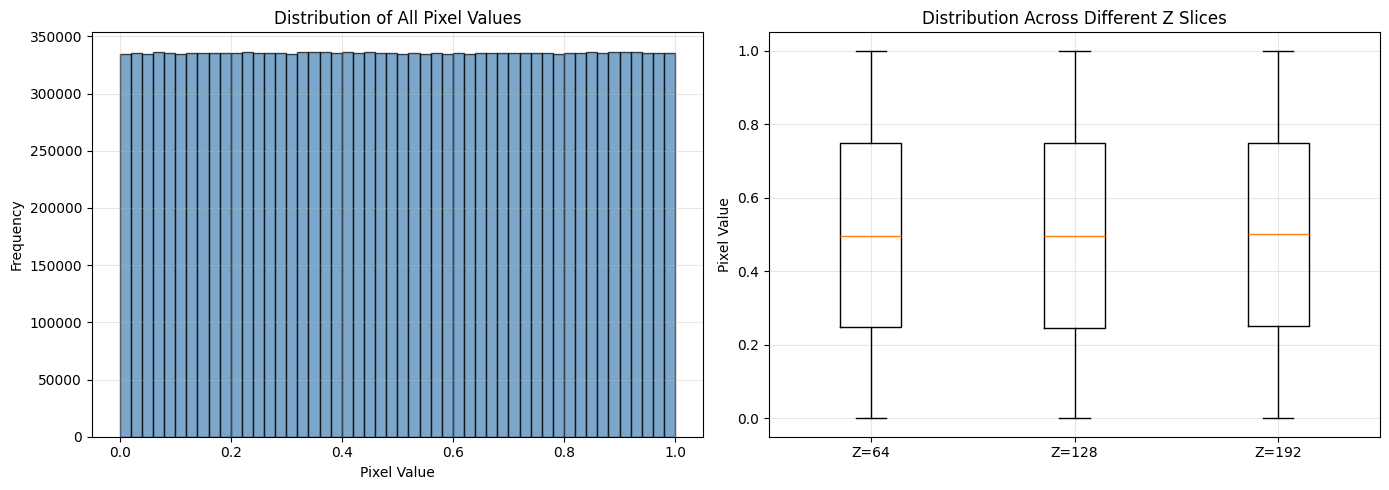

Data statistics:
  Min: 0.000
  Max: 1.000
  Mean: 0.500
  Std: 0.289


In [5]:
# Analyze data distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of all pixel values
axes[0].hist(sample_image.flatten(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Pixel Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of All Pixel Values')
axes[0].grid(True, alpha=0.3)

# Box plot comparing different slices
sample_slices = [
    sample_image[image_size//4, :, :].flatten(),
    sample_image[image_size//2, :, :].flatten(),
    sample_image[3*image_size//4, :, :].flatten()
]
axes[1].boxplot(sample_slices, labels=['Z=64', 'Z=128', 'Z=192'])
axes[1].set_ylabel('Pixel Value')
axes[1].set_title('Distribution Across Different Z Slices')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Data statistics:")
print(f"  Min: {sample_image.min():.3f}")
print(f"  Max: {sample_image.max():.3f}")
print(f"  Mean: {sample_image.mean():.3f}")
print(f"  Std: {sample_image.std():.3f}")

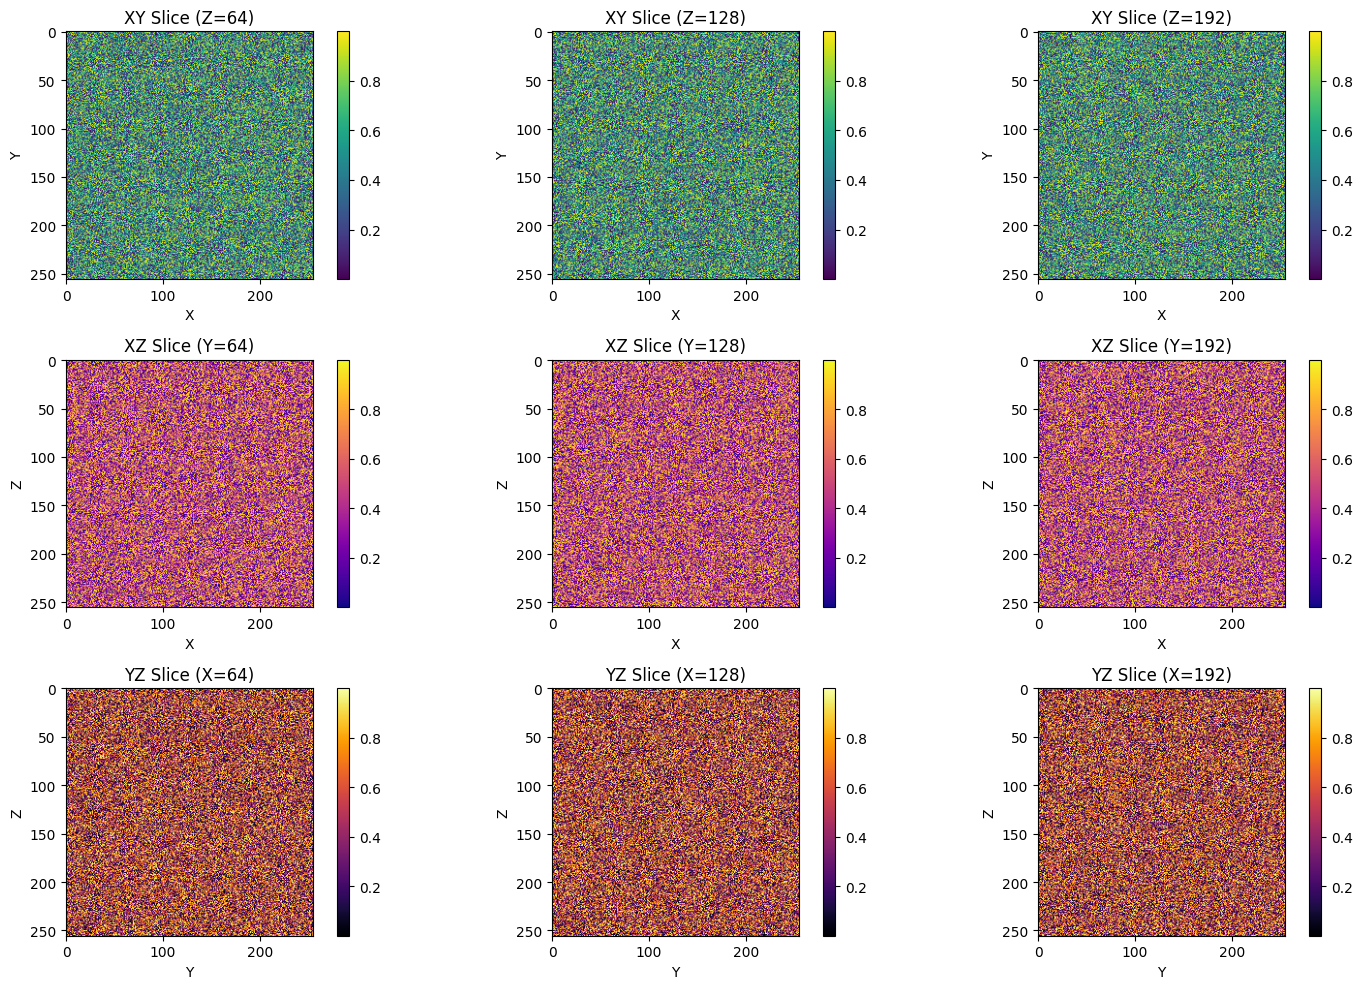


✓ Visualized 9 different slices through the 3D volume


In [6]:
# Visualize slices through the 3D data
fig = plt.figure(figsize=(15, 10))

# XY slices at different Z positions
for i, z_pos in enumerate([image_size//4, image_size//2, 3*image_size//4]):
    ax = plt.subplot(3, 3, i+1)
    im = ax.imshow(sample_image[z_pos, :, :], cmap='viridis')
    ax.set_title(f'XY Slice (Z={z_pos})')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.colorbar(im, ax=ax, fraction=0.046)

# XZ slices at different Y positions
for i, y_pos in enumerate([image_size//4, image_size//2, 3*image_size//4]):
    ax = plt.subplot(3, 3, i+4)
    im = ax.imshow(sample_image[:, y_pos, :], cmap='plasma')
    ax.set_title(f'XZ Slice (Y={y_pos})')
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    plt.colorbar(im, ax=ax, fraction=0.046)

# YZ slices at different X positions
for i, x_pos in enumerate([image_size//4, image_size//2, 3*image_size//4]):
    ax = plt.subplot(3, 3, i+7)
    im = ax.imshow(sample_image[:, :, x_pos], cmap='inferno')
    ax.set_title(f'YZ Slice (X={x_pos})')
    ax.set_xlabel('Y')
    ax.set_ylabel('Z')
    plt.colorbar(im, ax=ax, fraction=0.046)

plt.tight_layout()
plt.show()

print("\n✓ Visualized 9 different slices through the 3D volume")

## 3. Test Different Compression Methods

Let's benchmark different compression codecs: Blosc, GZip, Zstd, and no compression.

In [8]:
# Setup benchmark parameters
output_dir = pathlib.Path("data/output/demo_benchmarks")
output_dir.mkdir(parents=True, exist_ok=True)

chunk_size = 64  # Try different chunk sizes: 32, 64, 128
chunks = (chunk_size, chunk_size, chunk_size)
zarr_spec = 3  # Use Zarr spec version 3

# Dictionary to store results
results = {}

### 3.1 Blosc Compression

In [9]:
# Test Blosc compression (fast compression, good for scientific data)
store_path = output_dir / "blosc_compressed.zarr"
blosc_compressor = read_write_zarr.get_blosc_compressor(
    cname="zstd",  # compression algorithm: zstd, lz4, zlib
    clevel=5,       # compression level: 0-9
    shuffle="shuffle",  # shuffle, noshuffle, bitshuffle
    zarr_spec=zarr_spec
)

# Benchmark write
utils.remove_output_dir(store_path)
start_time = time.time()
read_write_zarr.write_zarr_array(
    sample_image,
    store_path,
    overwrite=False,
    chunks=chunks,
    compressor=blosc_compressor,
    zarr_spec=zarr_spec
)
write_time = time.time() - start_time

# Benchmark read
start_time = time.time()
read_image = read_write_zarr.read_zarr_array(store_path)
read_time = time.time() - start_time

# Get compression ratio and storage size
compression_ratio = read_write_zarr.get_compression_ratio(store_path)
storage_size = utils.get_directory_size(store_path) / (1024**2)

results['blosc'] = {
    'write_time': write_time,
    'read_time': read_time,
    'compression_ratio': compression_ratio,
    'storage_size_mb': storage_size
}

print(f"Blosc Results:")
print(f"  Write time: {write_time:.3f}s")
print(f"  Read time: {read_time:.3f}s")
print(f"  Compression ratio: {compression_ratio:.2f}x")
print(f"  Storage size: {storage_size:.2f} MB")
print(f"  Data integrity: {np.allclose(sample_image, read_image)}")

Blosc Results:
  Write time: 0.089s
  Read time: 0.025s
  Compression ratio: 1.21x
  Storage size: 52.72 MB
  Data integrity: True


### 3.2 GZip Compression

In [10]:
# Test GZip compression (standard compression, widely supported)
store_path = output_dir / "gzip_compressed.zarr"
gzip_compressor = read_write_zarr.get_gzip_compressor(
    level=6,  # compression level: 1-9
    zarr_spec=zarr_spec
)

utils.remove_output_dir(store_path)
start_time = time.time()
read_write_zarr.write_zarr_array(
    sample_image,
    store_path,
    overwrite=False,
    chunks=chunks,
    compressor=gzip_compressor,
    zarr_spec=zarr_spec
)
write_time = time.time() - start_time

start_time = time.time()
read_image = read_write_zarr.read_zarr_array(store_path)
read_time = time.time() - start_time

compression_ratio = read_write_zarr.get_compression_ratio(store_path)
storage_size = utils.get_directory_size(store_path) / (1024**2)

results['gzip'] = {
    'write_time': write_time,
    'read_time': read_time,
    'compression_ratio': compression_ratio,
    'storage_size_mb': storage_size
}

print(f"GZip Results:")
print(f"  Write time: {write_time:.3f}s")
print(f"  Read time: {read_time:.3f}s")
print(f"  Compression ratio: {compression_ratio:.2f}x")
print(f"  Storage size: {storage_size:.2f} MB")
print(f"  Data integrity: {np.allclose(sample_image, read_image)}")

GZip Results:
  Write time: 0.224s
  Read time: 0.045s
  Compression ratio: 1.11x
  Storage size: 57.47 MB
  Data integrity: True


### 3.3 Zstd Compression

In [11]:
# Test Zstd compression (good balance of speed and compression ratio)
store_path = output_dir / "zstd_compressed.zarr"
zstd_compressor = read_write_zarr.get_zstd_compressor(
    level=5,  # compression level: 1-22
    zarr_spec=zarr_spec
)

utils.remove_output_dir(store_path)
start_time = time.time()
read_write_zarr.write_zarr_array(
    sample_image,
    store_path,
    overwrite=False,
    chunks=chunks,
    compressor=zstd_compressor,
    zarr_spec=zarr_spec
)
write_time = time.time() - start_time

start_time = time.time()
read_image = read_write_zarr.read_zarr_array(store_path)
read_time = time.time() - start_time

compression_ratio = read_write_zarr.get_compression_ratio(store_path)
storage_size = utils.get_directory_size(store_path) / (1024**2)

results['zstd'] = {
    'write_time': write_time,
    'read_time': read_time,
    'compression_ratio': compression_ratio,
    'storage_size_mb': storage_size
}

print(f"Zstd Results:")
print(f"  Write time: {write_time:.3f}s")
print(f"  Read time: {read_time:.3f}s")
print(f"  Compression ratio: {compression_ratio:.2f}x")
print(f"  Storage size: {storage_size:.2f} MB")
print(f"  Data integrity: {np.allclose(sample_image, read_image)}")

Zstd Results:
  Write time: 0.035s
  Read time: 0.021s
  Compression ratio: 1.12x
  Storage size: 57.26 MB
  Data integrity: True


### 3.4 No Compression (Baseline)

In [12]:
# Test without compression (baseline)
store_path = output_dir / "no_compression.zarr"

utils.remove_output_dir(store_path)
start_time = time.time()
read_write_zarr.write_zarr_array(
    sample_image,
    store_path,
    overwrite=False,
    chunks=chunks,
    compressor=None,
    zarr_spec=zarr_spec
)
write_time = time.time() - start_time

start_time = time.time()
read_image = read_write_zarr.read_zarr_array(store_path)
read_time = time.time() - start_time

compression_ratio = read_write_zarr.get_compression_ratio(store_path)
storage_size = utils.get_directory_size(store_path) / (1024**2)

results['no_compression'] = {
    'write_time': write_time,
    'read_time': read_time,
    'compression_ratio': compression_ratio,
    'storage_size_mb': storage_size
}

print(f"No Compression Results:")
print(f"  Write time: {write_time:.3f}s")
print(f"  Read time: {read_time:.3f}s")
print(f"  Compression ratio: {compression_ratio:.2f}x")
print(f"  Storage size: {storage_size:.2f} MB")
print(f"  Data integrity: {np.allclose(sample_image, read_image)}")

No Compression Results:
  Write time: 0.029s
  Read time: 0.017s
  Compression ratio: 1.00x
  Storage size: 64.00 MB
  Data integrity: True


## 4. Visualize Results

Let's create some plots to compare the different compression methods.

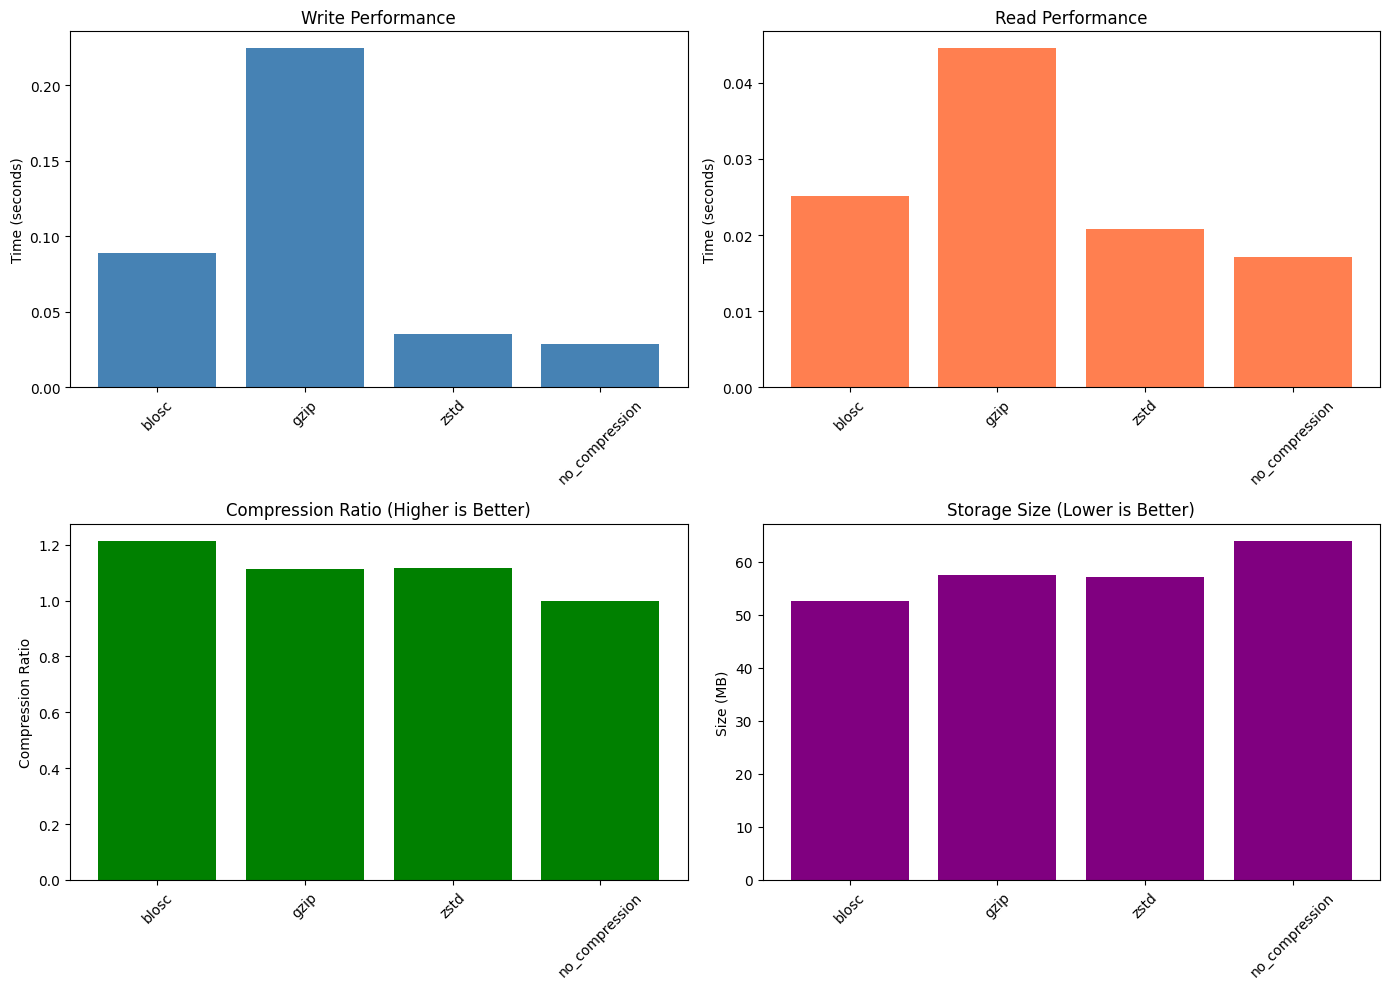

In [13]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

methods = list(results.keys())
write_times = [results[m]['write_time'] for m in methods]
read_times = [results[m]['read_time'] for m in methods]
compression_ratios = [results[m]['compression_ratio'] for m in methods]
storage_sizes = [results[m]['storage_size_mb'] for m in methods]

# Plot 1: Write times
axes[0, 0].bar(methods, write_times, color='steelblue')
axes[0, 0].set_ylabel('Time (seconds)')
axes[0, 0].set_title('Write Performance')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Read times
axes[0, 1].bar(methods, read_times, color='coral')
axes[0, 1].set_ylabel('Time (seconds)')
axes[0, 1].set_title('Read Performance')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Compression ratios
axes[1, 0].bar(methods, compression_ratios, color='green')
axes[1, 0].set_ylabel('Compression Ratio')
axes[1, 0].set_title('Compression Ratio (Higher is Better)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Storage sizes
axes[1, 1].bar(methods, storage_sizes, color='purple')
axes[1, 1].set_ylabel('Size (MB)')
axes[1, 1].set_title('Storage Size (Lower is Better)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Summary Table

In [14]:
import pandas as pd

# Create a summary table
summary_df = pd.DataFrame(results).T
summary_df = summary_df.round(3)
summary_df.columns = ['Write Time (s)', 'Read Time (s)', 'Compression Ratio', 'Storage Size (MB)']

print("\nBenchmark Summary:")
print(summary_df)

# Find the best methods
print("\nBest Methods:")
print(f"  Fastest write: {summary_df['Write Time (s)'].idxmin()}")
print(f"  Fastest read: {summary_df['Read Time (s)'].idxmin()}")
print(f"  Best compression: {summary_df['Compression Ratio'].idxmax()}")
print(f"  Smallest storage: {summary_df['Storage Size (MB)'].idxmin()}")


Benchmark Summary:
                Write Time (s)  Read Time (s)  Compression Ratio  \
blosc                    0.089          0.025              1.214   
gzip                     0.224          0.045              1.114   
zstd                     0.035          0.021              1.118   
no_compression           0.029          0.017              1.000   

                Storage Size (MB)  
blosc                      52.718  
gzip                       57.468  
zstd                       57.260  
no_compression             64.001  

Best Methods:
  Fastest write: no_compression
  Fastest read: no_compression
  Best compression: blosc
  Smallest storage: blosc


## 6. Next Steps

Now that you've seen the basics, you can:

1. **Test with real data**: Replace the random data with your actual imaging data
2. **Experiment with parameters**:
   - Try different chunk sizes (32, 64, 128, 256)
   - Adjust compression levels
   - Test different Blosc algorithms (zstd, lz4, zlib)
   - Try different shuffle options (shuffle, bitshuffle, noshuffle)

3. **Use the full benchmark suite**: Run the complete benchmarks using tox:
   ```bash
   # Quick test with dev image
   tox -- --benchmark-only --image=dev --rounds=3
   
   # Full benchmark with a real dataset
   tox -- --benchmark-only --image=heart --config=all --benchmark-storage=data/results/heart
   ```

4. **Generate plots**: After running the full benchmarks, create plots with:
   ```bash
   python src/zarr_benchmarks/create_plots.py
   ```

5. **Read the full documentation**: Visit [https://heftieproject.github.io/zarr-benchmarks/](https://heftieproject.github.io/zarr-benchmarks/)

## Tips for Choosing Compression Settings

- **Blosc**: Fast compression/decompression, great for interactive work, good for scientific data
- **GZip**: Widely supported, moderate speed, good compression ratio
- **Zstd**: Good balance of speed and compression, becoming more popular
- **No compression**: Fastest I/O but largest storage, use if storage is not a concern

**Chunk size considerations**:
- Smaller chunks: Better for accessing small regions, more overhead
- Larger chunks: Better for sequential access, more memory per read
- Rule of thumb: Match your typical access patterns

**Compression level**:
- Lower levels (1-3): Faster but less compression
- Higher levels (7-9): Slower but better compression
- Mid-range (4-6): Good balance for most use cases